In [59]:
pip install skforecast shap astral statsmodels lightgbm "seaborn>=0.11, <0.14"


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

# Warnings configuration
# ==============================================================================
import warnings

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 2.0.2


In [61]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

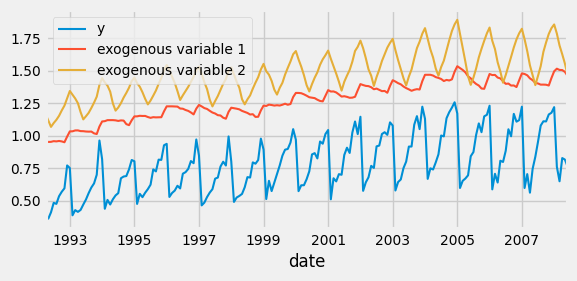

In [62]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(6, 2.7))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable 1')
data['exog_2'].plot(ax=ax, label='exogenous variable 2')
ax.legend(loc='upper left');

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


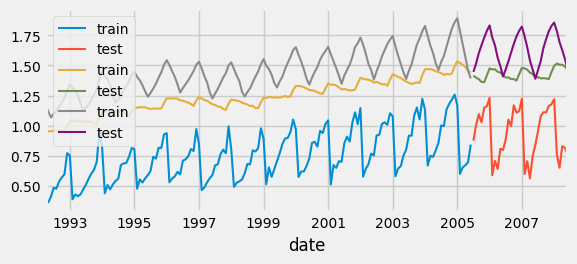

In [63]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
data_train['exog_1'].plot(ax=ax, label='train')
data_test['exog_1'].plot(ax=ax, label='test')
data_train['exog_2'].plot(ax=ax, label='train')
data_test['exog_2'].plot(ax=ax, label='test')
ax.legend(loc='upper left');

In [64]:
import os

os.makedirs("data", exist_ok=True)
data_train.to_csv('data/historical.csv', sep=',', index=True, header=True)
data_test[['exog_1', 'exog_2']].to_csv('data/sensors_data.csv', sep=',', index=True, header=True)
data_test['y'].to_csv('data/measured_value.csv', sep=',', index=True, header=True)

In [65]:
import boto3

# Read the data connection variables
key_id = os.getenv("AWS_ACCESS_KEY_ID")
secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
endpoint = os.getenv("AWS_S3_ENDPOINT")
bucket_name = os.getenv("AWS_S3_BUCKET")

# Upload the data
s3_client = boto3.client(
    "s3",
    aws_access_key_id=key_id,
    aws_secret_access_key=secret_key,
    endpoint_url=endpoint,
    use_ssl=True
)

s3_client.upload_file('data/historical.csv', bucket_name, Key="data/historical.csv")
s3_client.upload_file('data/sensors_data.csv', bucket_name, Key="data/sensors_data.csv")
s3_client.upload_file('data/measured_value.csv', bucket_name, Key="data/measured_value.csv")